# **EXP - 3 - Baby Robot - PART 6**

# **Comparison of Bandit Algorithms**

In [8]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.pylabtools import figsize

"""
    System Setup
"""

# create 5 sockets in a fixed order
socket_order = [2,1,3,5,4]

# the true values of each socket
socket_means = [((q*2)+2) for q in socket_order]

# save the number of sockets
NUM_SOCKETS = len(socket_order)


"""
    Display Setup
"""

# display all floating point numbers to 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})


"""
    Helper Functions
"""

# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))



class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q



class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket=PowerSocket, socket_order=socket_order, multiplier=2, **kwargs ):

        # create supplied socket type with a mean value defined by socket order
        self.sockets = [socket((q*multiplier)+2, **kwargs) for q in socket_order]

        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        # the index of the best socket is the last in the socket_order list
        # - this is a one-based value so convert to zero-based
        self.optimal_socket_index = (socket_order[-1] - 1)

        # by default a socket tester records 2 bits of information over a run
        self.number_of_stats = kwargs.pop('number_of_stats', 2)


    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """

        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps

        # reset the actual number of steps that the test ran for
        self.total_steps = 0

        # monitor the total reward obtained over the run
        self.total_reward = 0

        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []

        # the actual reward obtained at each timestep
        self.reward_per_timestep = []

        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1,
                                            self.number_of_sockets,
                                            self.number_of_stats))

        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()


    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """

        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward

        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)

        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)


    def get_socket_stats( self, t ):
        """ get the current information from each socket """
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats

    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)

    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep

    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep

    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]

    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]

    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)

    def get_optimal_socket_percentage( self ):
        """ get the percentage of times the optimal socket was tried """
        final_trials = self.socket_stats[:,:,1][self.total_steps]
        return (final_trials[self.optimal_socket_index]/self.total_steps)

    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps


    def select_socket( self, t ):
        """ Greedy Socket Selection"""

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets])
        return socket_index


    def run( self, number_of_steps, maximum_total_reward = float('inf')):
        """ perform a single run, over the set of sockets,
            for the defined number of steps """

        # reset the run counters
        self.initialize_run(number_of_steps)

        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)

            # select a socket
            socket_index = self.select_socket(t)

            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)

            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break

        # save the actual number of steps that have been run
        self.total_steps = t

        # get the stats for each socket at the end of the run
        self.socket_stats[t+1] = self.get_socket_stats(t+1)

        return self.total_steps, self.total_reward


class SocketExperiment():
    """ setup and run repeated socket tests to get the average results """

    def __init__(self,
                 socket_tester = SocketTester,
                 number_of_tests = 1000,
                 number_of_steps = 30,
                 maximum_total_reward = float('inf'),
                 **kwargs ):

        self.socket_tester = socket_tester
        self.number_of_tests = number_of_tests
        self.number_of_steps = number_of_steps
        self.maximum_total_reward = maximum_total_reward
        self.number_of_sockets = self.socket_tester.number_of_sockets

    def initialize_run(self):

        # keep track of the average values over the run
        self.mean_total_reward = 0.
        self.optimal_selected = 0.
        self.mean_time_steps = 0.
        self.socket_percentages = np.zeros(self.number_of_sockets)
        self.estimates = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))
        self.number_of_trials = np.zeros(shape=(self.number_of_steps+1,self.number_of_sockets))

        # the cumulative total reward per timestep
        self.cumulative_reward_per_timestep = np.zeros(shape=(self.number_of_steps))

        # the actual reward obtained at each timestep
        self.reward_per_timestep = np.zeros(shape=(self.number_of_steps))

    def get_mean_total_reward(self):
        """ the final total reward averaged over the number of timesteps """
        return self.mean_total_reward

    def get_cumulative_reward_per_timestep(self):
        """ the cumulative total reward per timestep """
        return self.cumulative_reward_per_timestep

    def get_reward_per_timestep(self):
        """ the mean actual reward obtained at each timestep """
        return self.reward_per_timestep

    def get_optimal_selected(self):
        """ the mean times the optimal socket was selected """
        return self.optimal_selected

    def get_socket_percentages(self):
        """ the mean of the percentage times each socket was selected """
        return self.socket_percentages

    def get_estimates(self):
        """ per socket reward estimates """
        return self.estimates

    def get_number_of_trials(self):
        """ per socket number of trials """
        return self.number_of_trials

    def get_mean_time_steps(self):
        """ the average number of trials of each test """
        return self.mean_time_steps

    def update_mean( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value """
        return (1 - 1.0/n) * current_mean + (1.0/n) * new_value

    def update_mean_array( self, current_mean, new_value, n ):
        """ calculate the new mean from the previous mean and the new value for an array """

        new_value = np.array(new_value)

        # pad the new array with its last value to make sure its the same length as the original
        pad_length = (current_mean.shape[0] - new_value.shape[0])

        if pad_length > 0:
            new_array = np.pad(new_value,(0,pad_length), mode='constant', constant_values=new_value[-1])
        else:
            new_array = new_value

        return (1 - 1.0/n) * current_mean + (1.0/n) * new_array

    def record_test_stats(self,n):
        """ update the mean value for each statistic being tracked over a run """

        # calculate the new means from the old means and the new value
        tester = self.socket_tester
        self.mean_total_reward = self.update_mean( self.mean_total_reward, tester.get_mean_reward(), n)
        self.optimal_selected = self.update_mean( self.optimal_selected, tester.get_optimal_socket_percentage(), n)
        self.socket_percentages = self.update_mean( self.socket_percentages, tester.get_socket_percentages(), n)
        self.mean_time_steps = self.update_mean( self.mean_time_steps, tester.get_time_steps(), n)

        self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                      tester.get_total_reward_per_timestep(), n)

        # check if the tests are only running until a maximum reward value is reached
        if self.maximum_total_reward == float('inf'):

            self.estimates = self.update_mean_array( self.estimates, tester.get_estimates(), n)
            self.cumulative_reward_per_timestep = self.update_mean_array( self.cumulative_reward_per_timestep,
                                                                          tester.get_total_reward_per_timestep(), n)
            self.reward_per_timestep = self.update_mean_array( self.reward_per_timestep, tester.get_reward_per_timestep(), n)
            self.number_of_trials = self.update_mean_array( self.number_of_trials, tester.get_number_of_trials(), n)

    def run(self):
        """ repeat the test over a set of sockets for the specified number of trials """

        # do the specified number of runs for a single test
        self.initialize_run()
        for n in range(1,self.number_of_tests+1):

            # do one run of the test
            self.socket_tester.run( self.number_of_steps, self.maximum_total_reward )
            self.record_test_stats(n)

## The Standard Power Socket

In [1]:
class PowerSocket:
    """ the base power socket class """

    def __init__(self, q):
        self.q = q        # the true reward value
        self.initialize() # reset the socket

    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value
        self.n = 0   # the number of times this socket has been tried

    def charge(self):
        """ return a random amount of charge """

        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = np.random.randn() + self.q

        # never allow a charge less than 0 to be returned
        return 0 if value < 0 else value

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def sample(self,t):
        """ return an estimate of the socket's reward value """
        return self.Q

## The Optimistic Greedy Power Socket

In [2]:
# Create an Optimistic Socket class by inheriting from the standard Power Socket
class OptimisticSocket( PowerSocket ):
    def __init__( self, q, **kwargs ):

        # get the initial reqrd estimate from the kwargs
        self.initial_estimate = kwargs.pop('initial_estimate', 0.)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def initialize(self):
        # estimate of this socket's reward value
        # - set to supplied initial value
        self.Q = self.initial_estimate
        self.n = 0

## The Upper Confidence Bounds Socket

In [3]:
class UCBSocket( PowerSocket ):

    def __init__( self, q, **kwargs ):
        """ initialize the UCB socket """

        # store the confidence level controlling exploration
        self.confidence_level = kwargs.pop('confidence_level', 2.0)

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def uncertainty(self, t):
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))

    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t)

## The Gaussian Thompson Sampling Socket

In [4]:
class GaussianThompsonSocket( PowerSocket ):
    def __init__(self, q):

        self.τ_0 = 0.0001  # the posterior precision
        self.μ_0 = 1       # the posterior mean

        # pass the true reward value to the base PowerSocket
        super().__init__(q)

    def sample(self,t):
        """ return a value from the the posterior normal distribution """
        return (np.random.randn() / np.sqrt(self.τ_0)) + self.μ_0

    def update(self,R):
        """ update this socket after it has returned reward value 'R' """

        # do a standard update of the estimated mean
        super().update(R)

        # update the mean and precision of the posterior
        self.μ_0 = ((self.τ_0 * self.μ_0) + (self.n * self.Q))/(self.τ_0 + self.n)
        self.τ_0 += 1

## The Epsilon Greedy Socket Tester

In [9]:
class EpsilonGreedySocketTester( SocketTester ):

    def __init__(self, socket_order=socket_order, multiplier=2, epsilon = 0.2 ):

        # create a standard socket tester
        super().__init__(socket_order=socket_order, multiplier=multiplier)

        # save the probability of selecting the non-greedy action
        self.epsilon = epsilon


    def select_socket( self, t ):
        """ Epsilon-Greedy Socket Selection"""

        # probability of selecting a random socket
        p = np.random.random()

        # if the probability is less than epsilon then a random socket is chosen from the complete set
        if p < self.epsilon:
            socket_index = np.random.choice(self.number_of_sockets)
        else:
            # choose the socket with the current highest mean reward or arbitrary select a socket in the case of a tie
            socket_index = random_argmax([socket.sample(t) for socket in self.sockets])

        return socket_index

## Testing on the standard power socket problem

In [10]:
methods = []
rewards = []
mean_rewards = []

def run_multiple_tests( tester, max_steps = 500, show_socket_percentages = True ):
    number_of_tests = 100
    number_of_steps = max_steps
    maximum_total_reward = 3600

    experiment = SocketExperiment(socket_tester   = tester,
                                  number_of_tests = number_of_tests,
                                  number_of_steps = number_of_steps,
                                  maximum_total_reward = maximum_total_reward)
    experiment.run()

    print(f'Mean Reward per Time Step = {experiment.get_mean_total_reward():0.3f}')
    print(f'Optimal Socket Selected = {experiment.get_optimal_selected():0.3f}')
    print(f'Average Number of Trials Per Run = {experiment.get_mean_time_steps():0.3f}')
    if show_socket_percentages:
      print(f'Socket Percentages = {experiment.get_socket_percentages()}')

    rewards.append(experiment.get_cumulative_reward_per_timestep())
    mean_rewards.append(f"{experiment.get_mean_total_reward():0.3f}")

In [11]:
# Greedy Selection
run_multiple_tests( SocketTester( PowerSocket ) )

Mean Reward per Time Step = 7.500
Optimal Socket Selected = 0.150
Average Number of Trials Per Run = 435.150
Socket Percentages = [0.270 0.240 0.150 0.150 0.190]


In [12]:
# Epsilon Greedy
run_multiple_tests( EpsilonGreedySocketTester( epsilon = 0.2 ) )

Mean Reward per Time Step = 11.073
Optimal Socket Selected = 0.792
Average Number of Trials Per Run = 325.870
Socket Percentages = [0.045 0.044 0.050 0.792 0.069]


In [13]:
# Optimistic Greedy
run_multiple_tests( SocketTester( OptimisticSocket, initial_estimate = 20. ))

Mean Reward per Time Step = 11.970
Optimal Socket Selected = 0.986
Average Number of Trials Per Run = 301.280
Socket Percentages = [0.003 0.003 0.003 0.986 0.004]


In [14]:
# UCB
run_multiple_tests( SocketTester( UCBSocket, confidence_level = 0.6 ))

Mean Reward per Time Step = 11.971
Optimal Socket Selected = 0.985
Average Number of Trials Per Run = 301.240
Socket Percentages = [0.003 0.003 0.003 0.985 0.005]


In [15]:
# Thompson Sampling
run_multiple_tests( SocketTester( GaussianThompsonSocket ))

Mean Reward per Time Step = 12.034
Optimal Socket Selected = 1.000
Average Number of Trials Per Run = 299.690
Socket Percentages = [0.000 0.000 0.000 1.000 0.000]


Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

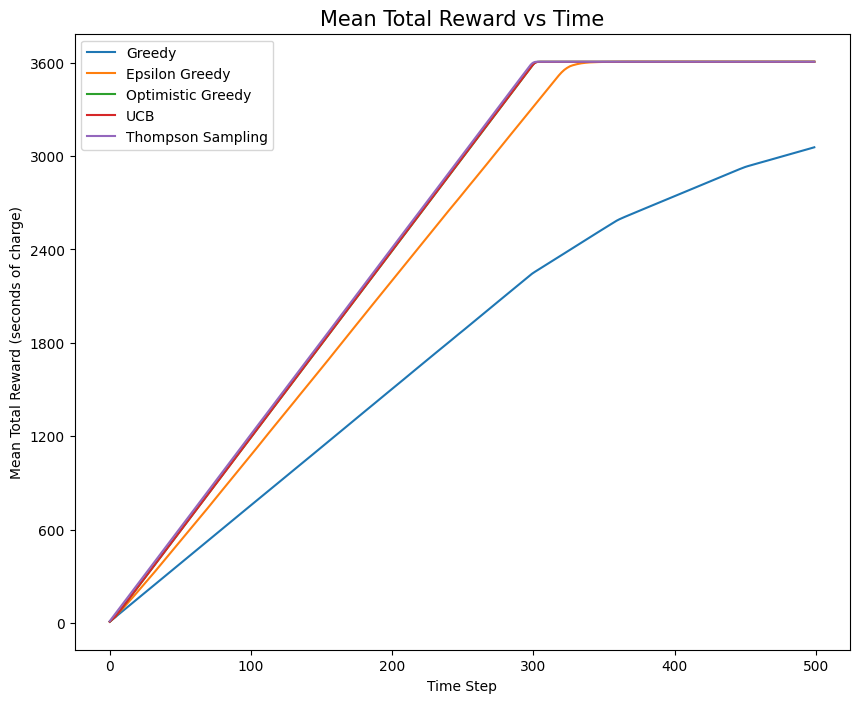

In [16]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')

plt.legend()
plt.title('Mean Total Reward vs Time', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

## Increasing the Problem Difficulty

In [17]:
NUM_SOCKETS = 10

# using a fixed ordering for consistency
socket_order = [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]

print(f"Socket Order: {socket_order}")

MULTIPLIER = 0.2

# create the sockets
# - the mean value of each socket is derived from the socket order index, which is doubled to give
#   distinct values and offset by 2 to keep the distribution above zero
sockets = [PowerSocket((q*MULTIPLIER)+2) for q in socket_order]

# iterate through each of the sockets
# - rewards will contain the charge returned at all of the time steps for each socket
# - using a very large number of time steps just to create sufficient data to get smooth plots of socket output
TOTAL_STEPS = 100000

rewards = np.zeros(shape=(TOTAL_STEPS,NUM_SOCKETS))
for socket_number,socket in enumerate(sockets):
    # get charge from the socket for the defined number of steps
    for t in range(TOTAL_STEPS): rewards[t,socket_number] = socket.charge()

Socket Order: [7, 5, 1, 10, 2, 3, 6, 8, 9, 4]


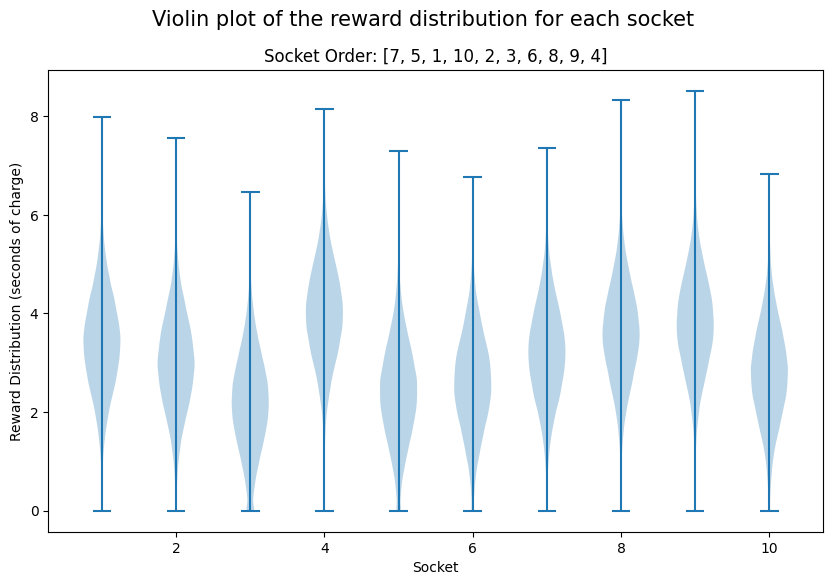

In [18]:
# plot the charge we got from the sockets
plt.figure(figsize=(10,6))
plt.violinplot(rewards)
plt.suptitle('Violin plot of the reward distribution for each socket', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket')
plt.ylabel('Reward Distribution (seconds of charge)')
plt.show()

<ipython-input-19-3f32489dca7d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
<ipython-input-19-3f32489dca7d>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
sim

Text(0, 0.5, 'Density')

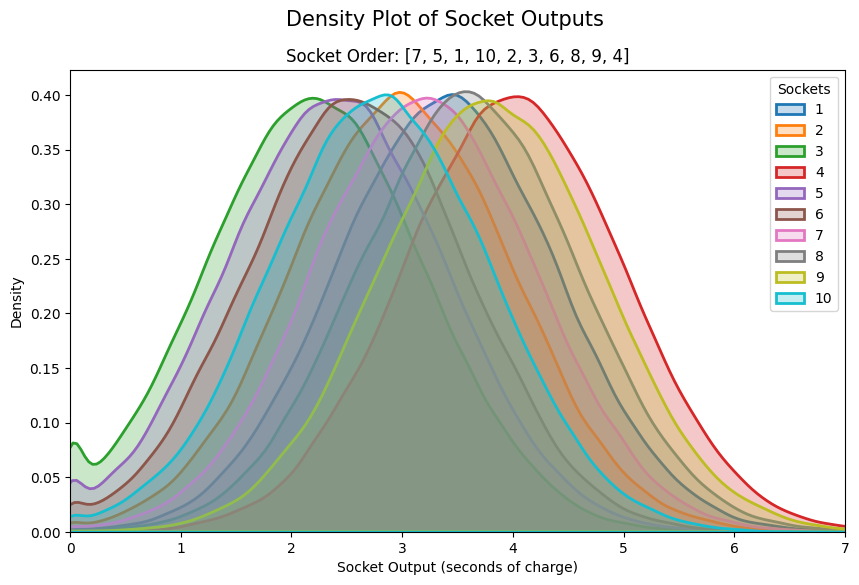

In [19]:
plt.figure(figsize=(10,6))

for socket_number in range(NUM_SOCKETS):
    sns.distplot(pd.DataFrame(rewards[:,socket_number]), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                 label = f'{socket_number+1}');

# Plot formatting
plt.xlim(0, 7)
plt.legend(title = 'Sockets')
plt.suptitle('Density Plot of Socket Outputs', fontsize=15)
plt.title(f'Socket Order: {socket_order}')
plt.xlabel('Socket Output (seconds of charge)')
plt.ylabel('Density')

In [20]:
rewards = []

def run_tests( tester, max_steps = 1000 ):
    run_multiple_tests( tester, max_steps = max_steps )

In [21]:
# Greedy Selection
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER ) )

Mean Reward per Time Step = 2.992
Optimal Socket Selected = 0.090
Average Number of Trials Per Run = 987.420
Socket Percentages = [0.060 0.140 0.120 0.090 0.100 0.170 0.100 0.100 0.040 0.080]


In [22]:
# Epsilon Greedy
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))

Mean Reward per Time Step = 3.769
Optimal Socket Selected = 0.648
Average Number of Trials Per Run = 955.560
Socket Percentages = [0.030 0.023 0.021 0.648 0.022 0.021 0.029 0.042 0.142 0.022]


In [23]:
# Optimistic Greedy
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))

Mean Reward per Time Step = 3.844
Optimal Socket Selected = 0.448
Average Number of Trials Per Run = 935.560
Socket Percentages = [0.023 0.002 0.001 0.448 0.001 0.001 0.013 0.120 0.389 0.002]


In [24]:
# UCB
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 ))

Mean Reward per Time Step = 3.935
Optimal Socket Selected = 0.782
Average Number of Trials Per Run = 915.670
Socket Percentages = [0.010 0.004 0.002 0.782 0.002 0.002 0.005 0.036 0.153 0.003]


In [25]:
# Thompson Sampling
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 4.005
Optimal Socket Selected = 0.993
Average Number of Trials Per Run = 899.470
Socket Percentages = [0.000 0.000 0.000 0.993 0.000 0.000 0.000 0.003 0.003 0.000]


Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

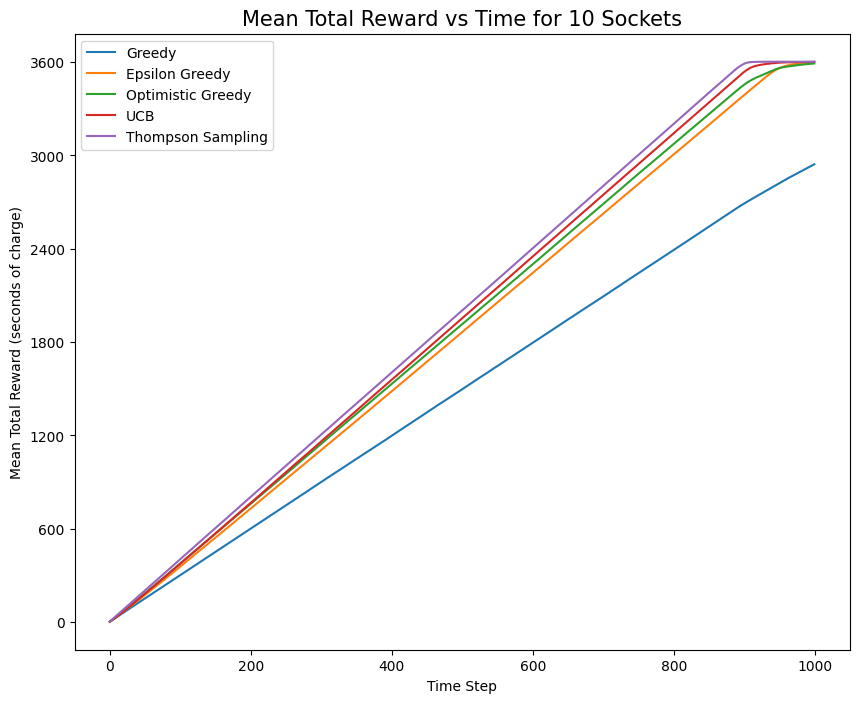

In [26]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')

plt.legend()
plt.title('Mean Total Reward vs Time for 10 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')

In [27]:
# create the specified number of sockets in a random order
NUM_SOCKETS = 100
socket_order = random.sample(range(1,1+NUM_SOCKETS), NUM_SOCKETS)

MULTIPLIER = 0.1

rewards = []

def run_tests( tester, max_steps = 300 ):
    run_multiple_tests( tester, max_steps = max_steps, show_socket_percentages = False )

In [28]:
run_tests( SocketTester( PowerSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 6.888
Optimal Socket Selected = 0.020
Average Number of Trials Per Run = 299.000


In [29]:
run_tests( EpsilonGreedySocketTester( socket_order, multiplier = MULTIPLIER, epsilon = 0.2 ))

Mean Reward per Time Step = 10.453
Optimal Socket Selected = 0.003
Average Number of Trials Per Run = 299.000


In [30]:
run_tests( SocketTester( OptimisticSocket, socket_order, multiplier = MULTIPLIER, initial_estimate = 20. ))

Mean Reward per Time Step = 10.276
Optimal Socket Selected = 0.003
Average Number of Trials Per Run = 299.000


In [32]:
run_tests( SocketTester( UCBSocket, socket_order, multiplier = MULTIPLIER, confidence_level = 0.6 ))

Mean Reward per Time Step = 10.229
Optimal Socket Selected = 0.003
Average Number of Trials Per Run = 299.000


In [33]:
run_tests( SocketTester( GaussianThompsonSocket, socket_order, multiplier = MULTIPLIER ))

Mean Reward per Time Step = 12.004
Optimal Socket Selected = 0.000
Average Number of Trials Per Run = 298.720


Text(0, 0.5, 'Mean Total Reward (seconds of charge)')

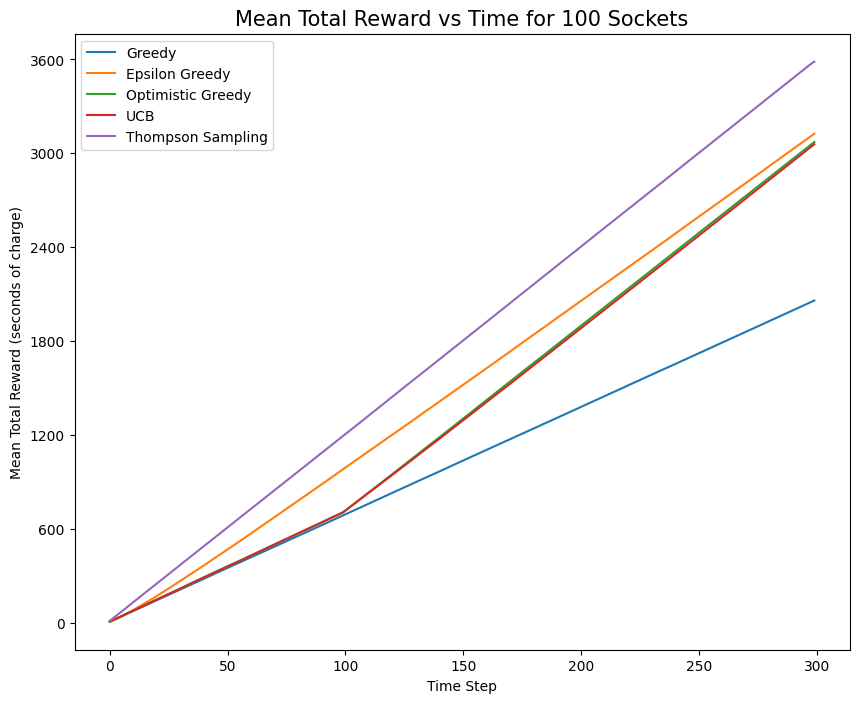

In [34]:
test_names = ['Greedy','Epsilon Greedy','Optimistic Greedy','UCB','Thompson Sampling']

plt.figure(figsize=(10,8))
plt.yticks(np.arange(0., 4200, 600))

for test in range(len(rewards)):
    plt.plot(rewards[test], label = f'{test_names[test]}')

plt.legend()
plt.title('Mean Total Reward vs Time for 100 Sockets', fontsize=15)
plt.xlabel('Time Step')
plt.ylabel('Mean Total Reward (seconds of charge)')